## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

**False, so there aren't missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# create the new dataset
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].count()

290585

In [11]:
df2['user_id'].nunique()

290584

**There are 290584 user_ids.**

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

**user_id 773192 is repeated.**

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# get indexes of duplicates
duplicated_indexes = df2[df2['user_id'].duplicated() == True]['user_id'].keys()
# drop duplicates
df2 = df2.drop(duplicated_indexes)
# check duplicates
df2[df2['user_id'].duplicated() == True]['user_id']

Series([], Name: user_id, dtype: int64)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == "new_page").mean()

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**The probabilities are very similar. Control group probability: 0.120, Treatment group probability: 0.119. I think there is no evidence that the control or a treatment has more conversions. And this difference is practically negligible**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} >= p_{new}$$

$$H_1: p_{old} < p_{new}$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1],n_new, p=(1-p_new,p_new))
new_page_converted

array([0, 1, 0, ..., 1, 1, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1],n_new, p=(1-p_old,p_old))
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0010804486958915366

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    # make conversion simulations for old and new pages
    new_page_converted = np.random.choice([0,1],n_new, p=(1-p_new,p_new))
    old_page_converted = np.random.choice([0,1],n_new, p=(1-p_old,p_old))
    # calculate the differences and add them to a list
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

**Because we didn't find large differenes between old and new pages, the distribution somewhere around 0 is what we expected.**

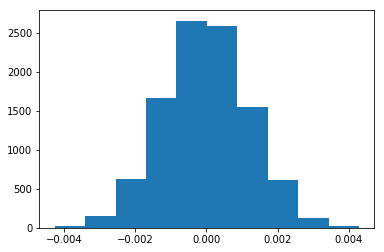

In [50]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [51]:
# calculate the differences of the proportion of converted people from the original data
p_new_actual = df2.query('landing_page == "new_page"')['converted'].mean()
p_old_actual = df2.query('landing_page == "old_page"')['converted'].mean()
actual_diff = p_new_actual - p_old_actual
actual_diff

-0.0015782389853555567

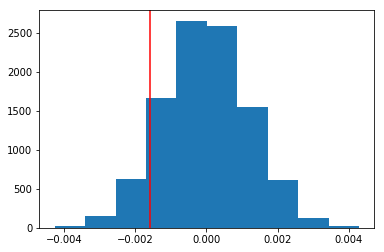

In [52]:
plt.hist(p_diffs)
# red line shows the original difference
plt.axvline(actual_diff, color='red');

In [53]:
(p_diffs > actual_diff).mean()

0.9073

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

**Our null hypothesis has a ">=" so we make a one tail test to see if we need to reject it or not. For this we make a distribution for the "=" part, where the two proportions are assumed equal.
p_diffs contains the differences between the proportions of the converted people of the old and new pages, assuming that two proportions are equal.
Here we compared this distribution with the difference calculated from our original data. This gives us p-value, which is the probability of getting at least as extreme value or larger as the compared one (right from the red line), assuming that the null hypothesis is true. So we here have a very large p value, so there is a very high chance that we can get this difference if the null hypothesis is true, so we don't reject it. We can't reject that $H_0: p_{old} >= p_{new}$**

**The difference is very small, it isn't significant practically, so even if we had statistical significance we should consider to neglect this difference.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
import statsmodels.api as sm
# calculate the parameters for proportions_ztest function
convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()
convert_new = df2.query('landing_page == "new_page" and converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [55]:
import statsmodels.api as sm

# two tailed version, if our H0 would be: p_new = p_old we would use this
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score, p_value

(-1.3109241984234394, 0.18988337448195103)

In [56]:
# one tail version, here we need this version for testing our hypothesis
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

**The z-score tells us, that how far are we from the distribution mean in standard deviations. The z-score assigns the point from where we calculate the p-value, wich tells us if we can reject the null hypothesis or not. This p-value is very close to the one we calculated before. Practically we have the same result, we can't reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [57]:
df2['intercept'] = 1
# create dummies from group column, we will need only 'ab_page'
df2[['_', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [58]:
import statsmodels.api as sm
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:29:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [60]:
# get the exponent
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.19, wich is high enough to retain the null hypothesis (if alpha = 0.05), so doesn't really matter if we use the old or new page. In part II we used a one-tail test, where the null hypothesis was: $H_0: p_{old} >= p_{new}$, and wanted to see if the new page is better or not. Here for the regression we used two tailed test and different null hypothesis: $H_0: p_{old} = p_{new}$, so the alternative hypothesis is that they are different.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

**It is a good idea to add other predictors, we can have a more accurate model. But multicollinearity can be a problem with more predictors, coefficients will be unstable, they can even change sign, so will be harder to interpret our results. We can make interactions as well to make a more accurate model, but with interactions, we lose interpretability.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [61]:
df_country = pd.read_csv('countries.csv')
df_country.tail()

,user_id,country
290579,653118,US
290580,878226,UK
290581,799368,UK
290582,655535,CA
290583,934996,UK


In [62]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0


In [63]:
# check countries
df_country['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [64]:
# make a new dataframe with the earlier and country variables
df_full = df2.merge(df_country, on='user_id', how='inner')
df_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [65]:
# make dummies for 'country'
df_full[['CA', 'UK', 'US']] = pd.get_dummies(df_full['country'])
df_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [66]:
# set and fit the logistic regression model
model = sm.Logit(df_full['converted'], df_full[['intercept', 'ab_page', 'UK', 'CA']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:29:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

**Answer:**

**The p-value for 'UK' and 'CA' are high, so we can't reject the null hypothesis, which means that they aren't statistically significant, the country doesn't have inpact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [67]:
# make a new column with the information from 'group' and 'country'
df_full['group_country'] = df_full['group'] + '_' + df_full['country']
df_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page,country,CA,UK,US,group_country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,control_US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,control_US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,control_US


In [68]:
# make dummies from the new column and add to df_full
df_dum = pd.get_dummies(df_full['group_country'])
df_full = pd.concat([df_full, df_dum], axis=1)
df_full.head()

,user_id,timestamp,group,landing_page,converted,intercept,_,ab_page,country,CA,UK,US,group_country,control_CA,control_UK,control_US,treatment_CA,treatment_UK,treatment_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,control_US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,control_US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US,0,0,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,control_US,0,0,1,0,0,0


In [69]:
# set and fit the model with the interactions
model = sm.Logit(df_full['converted'], df_full[['intercept', 'ab_page', 'UK', 'CA', 'treatment_UK', 'treatment_CA']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:29:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page         -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK              -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA              -0.0175      0.038     -0.465      0.642      -0.091       0.056
treatment_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
treatment_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
================================================================================
"""

**Answer:**

**The p-values are high, so this interactions aren't statistically significant. They doesn't have significant effect on conversion.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [70]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0